# Feedforward Neural Network (FNN)

## Single Layer Perceptron (No hidden layer)

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse
from pandas import DataFrame

#df = pd.read_csv("asset/csv/mnist_train.csv", sep=",")
df = pd.read_csv("https://quantummc.xyz/wp-content/uploads/2020/08/feedforward-neural-network-example-1.csv", sep=",")

print(df)

       label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0          5    0    0    0    0    0    0    0    0    0  ...      0      0   
1          0    0    0    0    0    0    0    0    0    0  ...      0      0   
2          4    0    0    0    0    0    0    0    0    0  ...      0      0   
3          1    0    0    0    0    0    0    0    0    0  ...      0      0   
4          9    0    0    0    0    0    0    0    0    0  ...      0      0   
5          2    0    0    0    0    0    0    0    0    0  ...      0      0   
6          1    0    0    0    0    0    0    0    0    0  ...      0      0   
7          3    0    0    0    0    0    0    0    0    0  ...      0      0   
8          1    0    0    0    0    0    0    0    0    0  ...      0      0   
9          4    0    0    0    0    0    0    0    0    0  ...      0      0   
10         3    0    0    0    0    0    0    0    0    0  ...      0      0   
11         5    0    0    0    0    0   

In [ ]:
X = df.drop(columns = 'label')
y = df['label']

A perceptron in this case is simply a feed-forward neural network with no hidden layers. This is equivalent to a multivariate logistic regression, or a Softmax regression.

In [ ]:
def computecost(theta,X,y,alpha):
    m = X.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(X,theta) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    cost = (-1 / m) * np.sum(y_mat * np.log(prob)) + (alpha/2)*np.sum(theta*theta) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(X.T,(y_mat - prob)) + alpha*theta #And compute the gradient for that loss
    return cost,grad

In [ ]:
def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

In [ ]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

In [ ]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,theta))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [ ]:
theta = np.zeros([X.shape[1],len(np.unique(y))])
iterations = 100
learningRate = 1e-5
losses = []

def gradient_descent(X,y,theta,alpha=0.01,iterations=100):
    cost_history = np.zeros(iterations)
    for it in range(iterations):
        cost,grad = computecost(theta,X,y,alpha)
        theta = theta - (learningRate * grad)
        cost_history[it]  = cost
        
    return theta, cost_history

In [ ]:
theta,cost_history = gradient_descent(X,y,theta,learningRate,iterations)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
#plt.yscale("log")
plt.title("Cost function using Gradient Descent")

In [ ]:
print(theta)

In [ ]:
np.savetxt("theta.csv", theta, delimiter=",")

### Testing the fit

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse
from pandas import DataFrame

#df = pd.read_csv("asset/csv/mnist_test.csv", sep=",")
df = pd.read_csv("https://quantummc.xyz/wp-content/uploads/2020/08/feedforward-neural-network-example-2.csv", sep=",")


In [ ]:
X = df.drop(columns = 'label')
y = df['label']

In [ ]:
prob,pred=getProbsAndPreds(X)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y,pred)

In [ ]:
print('The accuracy of this model is:', 100*accuracy,'%')

## Single Hidden Layer (Multiple Layer Perceptron)

Here, we will use the torch package to make our single hidden layer neural network.

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [44]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Now we make the dataset iterable.

In [45]:
batch_size = 60000
n_iters = 100
#num_epochs = n_iters / (len(train_dataset) / batch_size)
#num_epochs = int(num_epochs)
num_epochs=100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Then we define what kind of neural network we want to set up. Here it is a feedforward neural network.

Here, we will use a Rectified Linear Unit activation because it provides faster convergence than sigmoid or tanh activation.

In [46]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

Our images are 28x28 pixels, so our input dimensions is 784 dimensions. We will have a hidden layer of 100 hidden neurons. And our output will be 10, because there are 0-9 digits 

In [47]:
input_dim = 28*28
hidden_dim = 200
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [48]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

We will use cross entropy loss because this is the most appropriate loss function for logistic/softmax regression.

In [49]:
criterion = nn.CrossEntropyLoss()

We will use the SGD optimizer defined within the torch package.

In [50]:
learning_rate = 0.2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [51]:
iter = 0
accuracy_history = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                images = images.view(-1, 28 * 28).requires_grad_().to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Making use of the GPU
                '''
                if torch.cuda.is_available():
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum()
                else:
                    correct += (predicted == labels).sum()
                '''
                correct += (predicted == labels).sum()

            accuracy = 100. * correct.item() / total
            accuracy_history.append(accuracy)
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1. Loss: 2.3364226818084717. Accuracy: 11.64
Iteration: 2. Loss: 2.298659324645996. Accuracy: 12.07
Iteration: 3. Loss: 2.290571689605713. Accuracy: 13.06
Iteration: 4. Loss: 2.284876823425293. Accuracy: 15.13
Iteration: 5. Loss: 2.279186725616455. Accuracy: 17.64
Iteration: 6. Loss: 2.2734782695770264. Accuracy: 20.73
Iteration: 7. Loss: 2.267773389816284. Accuracy: 23.39
Iteration: 8. Loss: 2.262007236480713. Accuracy: 26.37
Iteration: 9. Loss: 2.2562143802642822. Accuracy: 29.34
Iteration: 10. Loss: 2.250336170196533. Accuracy: 31.97
Iteration: 11. Loss: 2.2444510459899902. Accuracy: 34.3
Iteration: 12. Loss: 2.238450050354004. Accuracy: 36.38
Iteration: 13. Loss: 2.232363224029541. Accuracy: 38.44
Iteration: 14. Loss: 2.226207733154297. Accuracy: 40.54
Iteration: 15. Loss: 2.2199504375457764. Accuracy: 42.16
Iteration: 16. Loss: 2.2135767936706543. Accuracy: 43.58
Iteration: 17. Loss: 2.2070932388305664. Accuracy: 44.8
Iteration: 18. Loss: 2.200483560562134. Accuracy: 46

Below is a  plot of Accuracy vs Iteration. 

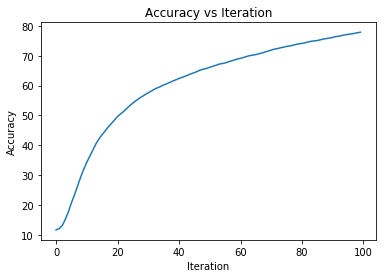

In [52]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
s = interpolate.InterpolatedUnivariateSpline(range(len(accuracy_history)), accuracy_history)
xnew = np.arange(0, 100, 1)
ynew=s(xnew)
#plt.figure()
plt.plot(xnew, ynew)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Iteration')
plt.show()
#plt.plot(accuracy_history)
#plt.xlabel("Iteration")
#plt.ylabel("Accuracy")
#plt.title("Accuracy vs Iteration")

As you can see, the accuracy is even worse compared to a single-layer perceptron. We will use a different method by splitting the dataset into batches, and iterating through the dataset. 

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())


batch_size = 600
n_iters = 2000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


input_dim = 28*28
hidden_dim = 500
output_dim = 10

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out



model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
accuracy_history = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                images = images.view(-1, 28 * 28).requires_grad_().to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                '''
                if torch.cuda.is_available():
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum()
                else:
                    correct += (predicted == labels).sum()
                '''
                correct += (predicted == labels).sum()

            accuracy = 100. * correct.item() / total
            accuracy_history.append(accuracy)
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 100. Loss: 1.8277956247329712. Accuracy: 67.3
Iteration: 200. Loss: 1.098745584487915. Accuracy: 78.81
Iteration: 300. Loss: 0.7527970671653748. Accuracy: 82.23
Iteration: 400. Loss: 0.6607846617698669. Accuracy: 85.55
Iteration: 500. Loss: 0.5529386401176453. Accuracy: 86.92
Iteration: 600. Loss: 0.48485657572746277. Accuracy: 87.86
Iteration: 700. Loss: 0.44814446568489075. Accuracy: 88.65
Iteration: 800. Loss: 0.4186347424983978. Accuracy: 88.99
Iteration: 900. Loss: 0.37985357642173767. Accuracy: 89.17
Iteration: 1000. Loss: 0.34570449590682983. Accuracy: 89.53
Iteration: 1100. Loss: 0.4103255271911621. Accuracy: 89.72
Iteration: 1200. Loss: 0.3532769978046417. Accuracy: 89.93
Iteration: 1300. Loss: 0.34923815727233887. Accuracy: 90.1
Iteration: 1400. Loss: 0.36477532982826233. Accuracy: 90.27
Iteration: 1500. Loss: 0.36095118522644043. Accuracy: 90.45
Iteration: 1600. Loss: 0.34261104464530945. Accuracy: 90.49
Iteration: 1700. Loss: 0.35779428482055664. Accuracy: 90.71


In [35]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())


batch_size = 600
n_iters = 2000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


input_dim = 28*28
hidden_dim = 512
output_dim = 10

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = 28*28
        # Linear function
        self.fc1 = nn.Linear(input_dim, 512)
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        #x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(self.sigmoid(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x



model = FeedforwardNeuralNetModel()

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.05

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)




epochs = 50
train_losses = []
test_losses = []
min_loss = np.Inf

for i in range(epochs):
    train_loss = 0
    train_acc = 0 
    test_loss = 0 
    test_acc = 0 
    
    # Training step
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()
        
    # Validation Step
    with torch.no_grad():
        model.eval()
        
        for images, labels in testloader:
            log_ps = model.forward(images)
            test_loss += criterion(log_ps, labels).item()
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(top_class.shape)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
    
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch:",i+1,
          "Train loss:",train_loss/len(trainloader),
          "TrainAcc:",100*train_acc/len(trainloader),
          "Test loss:",test_loss/len(testloader),
          "Test Acc:",100*test_acc/len(testloader))

Epoch: 1 Train loss: 2.2198796129226683 TrainAcc: 23.246666595339775 Test loss: 2.0964239485123577 Test Acc: 42.92156836565803
Epoch: 2 Train loss: 1.9705441558361054 TrainAcc: 47.33666676282883 Test loss: 1.7757966588525211 Test Acc: 68.19117595167721
Epoch: 3 Train loss: 1.626845668554306 TrainAcc: 61.07499951124191 Test loss: 1.4014984018662398 Test Acc: 73.14705918816959
Epoch: 4 Train loss: 1.2993903398513793 TrainAcc: 69.32833361625671 Test loss: 1.1073306974242716 Test Acc: 79.11764768993153
Epoch: 5 Train loss: 1.0606046241521836 TrainAcc: 74.2216666340828 Test loss: 0.9097881527508006 Test Acc: 81.80392174159779
Epoch: 6 Train loss: 0.902889894247055 TrainAcc: 77.3850000500679 Test loss: 0.7803307526251849 Test Acc: 83.24999984572915
Epoch: 7 Train loss: 0.796648052930832 TrainAcc: 79.41166687011719 Test loss: 0.6914655250661513 Test Acc: 84.29901985561146
Epoch: 8 Train loss: 0.7218539905548096 TrainAcc: 80.68333369493484 Test loss: 0.6268200365936055 Test Acc: 85.44607793583

In [ ]:
#model.fc1.weight.data

In [ ]:
#model.fc2.weight.data

print("The state dict keys: \n\n", model.state_dict().keys())

checkpoint = {'model': FeedforwardNeuralNetModel(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, './asset/model/FNN1.pth')

## 3 Hidden Layers

Now we turn our attention to the case of a FNN with 3 hidden layers. The gross format of the code is quite similar to the one with 1 hidden layer, except in the model class, the 2 extra layers are stated. Note, the same batch processing method is used.

In [57]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

batch_size = 600
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.Sigmoid()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.Sigmoid()
        
        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.Sigmoid()
        
        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
        
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.relu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

input_dim = 28*28
hidden_dim = 100
output_dim = 10


model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
accuracy_history = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()


        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                images = images.view(-1, 28 * 28).requires_grad_().to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100. * correct.item() / total
            accuracy_history.append(accuracy)
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 100. Loss: 2.3026442527770996. Accuracy: 11.35
Iteration: 200. Loss: 2.302074909210205. Accuracy: 10.28
Iteration: 300. Loss: 2.306206226348877. Accuracy: 11.35
Iteration: 400. Loss: 2.302682638168335. Accuracy: 11.35
Iteration: 500. Loss: 2.3025224208831787. Accuracy: 10.32
Iteration: 600. Loss: 2.305614471435547. Accuracy: 11.35
Iteration: 700. Loss: 2.29923939704895. Accuracy: 10.28
Iteration: 800. Loss: 2.3016533851623535. Accuracy: 10.1
Iteration: 900. Loss: 2.300278902053833. Accuracy: 11.35
Iteration: 1000. Loss: 2.296316623687744. Accuracy: 11.35
Iteration: 1100. Loss: 2.2997264862060547. Accuracy: 11.35
Iteration: 1200. Loss: 2.3005809783935547. Accuracy: 11.35
Iteration: 1300. Loss: 2.297628879547119. Accuracy: 11.35
Iteration: 1400. Loss: 2.305021286010742. Accuracy: 9.8
Iteration: 1500. Loss: 2.299114465713501. Accuracy: 11.35
Iteration: 1600. Loss: 2.3034605979919434. Accuracy: 11.35
Iteration: 1700. Loss: 2.2945854663848877. Accuracy: 10.28
Iteration: 1800. Los

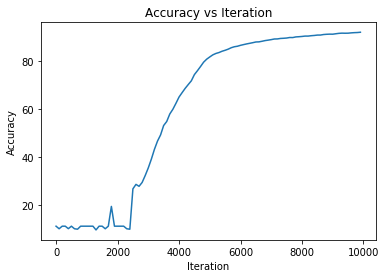

In [58]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
s = interpolate.InterpolatedUnivariateSpline(range(len(accuracy_history)), accuracy_history)
xnew = np.arange(0, 100, 1)
ynew=s(xnew)

plt.plot(100*xnew, ynew)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Iteration')
plt.show()